# 深層学習ノートブック-7 誤差逆伝播によるパラメータ更新
DL_notebook-4.5_train_test_split.ipynbにおける多項ロジスティック回帰の学習ループを  
スクラッチで実装したMLPとbackwardのコードで置き換え、実際にパラメータを更新してMLPを学習させる。  

In [ ]:
import torch
import torch.nn.functional as F  #pytorchの便利関数はFでimportすることが多い。
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
# python debugerをインポート
import pdb

## ■ backward（逆伝播）のスクラッチ実装結果
※現場ではこれらの関数は別ファイルでモジュール化して一元管理すること。

In [12]:
# 線形変換部分(パラメタ)の勾配の算出関数。Aはl-1層目の値で他はl層目の値。
def linear_backward(A, W, b, Z):
     # pytorch.tensorの.grad属性と区別するために.grad_として属性を定義している
     W.grad_ = Z.grad_.T @ A
     # bの値が一つ変わると、全データ分Lへ影響を及ぼすので、行方向(データ数の方向)にZ.grad_を足す。
     b.grad_ = torch.sum(Z.grad_, dim=0)
     # l-1層目のAはl層目の誤差（=Z.grad_）とl層目のWから計算できる。
     A.grad_ = Z.grad_ @ W


# ReLU関数
def relu_backward(Z, A):
     # 上式の"l番目の層における損失の誤差"における2行目と3行目を組み合わせてdL/dZを算出している
     # A.grad_はdL/dA, (Z > 0).float()はReLu関数の偏微分に相当する。
     Z.grad_ = A.grad_ * ( Z > 0 ).float()


# softmax関数と交差エントロピーの計算を同じ関数で実装する（pytorchでもこうなっている）
def softmax_cross_entropy(X, y_true):
    '''
    X: input tensor.行は各データ、列は各クラスを想定。
    y_true: tensor。One-Hot Encoding済みの正解ラベル。  
    '''
    max_val = X.max(dim=1, keepdim=True).values
    # 各要素のe^xを計算（これが分子になる）
    e_x = (X - max_val).exp()
    denominator = e_x.sum(dim=1, keepdim=True) + 1e-10
    softmax_out = e_x / denominator
    loss = - (y_true * torch.log(softmax_out + 1e-10)).sum() / y_true.shape[0]

    return loss, softmax_out


# tensorの線形結合を返す関数
def linear_comb(X, W, B):
    '''
    X, W, B: torch.tensor
    '''
    return X @ W.T + B


# ReLUの実装
def ReLU(Z):
    '''
    Z: torch.tensor
    '''
    # torch.whereによって要素ごとに条件が真・偽のときで別の値を返せる
    # 下記では0より大きい要素はzの値そのままで、0以下は0.になる。
    return torch.where(Z > 0 , Z, 0.)


In [64]:
# 隠れ層１層の場合のMLP（スクラッチ）
def forward_and_backward(X, W_1, W_2, B_1, B_2, y):
    '''
    X: features
    W: List of weights(each edge)
    B: List of Bias(each Layer)
    '''

    #########################
    #### 順伝播（forward）####
    #########################

    # 入力層→隠れ層
    Z1 = linear_comb(X, W_1, B_1)

    # 活性化関数適用
    A1 = ReLU(Z1)

    # 隠れ層→出力層
    Z2 = linear_comb(A1, W_2, B_2)

    # 最終出力。損失とソフトマックス関数の出力が返される
    loss, A2 = softmax_cross_entropy(Z2, y)


    #########################
    #### 逆伝播（backward）####
    #########################

    # 最終出力→出力層の出力のbackward。ここで各層の出力の勾配を求める。
    # ここでは出力層の活性化関数は恒等関数とし、
    # その出力にsoftmax_cross_entropyを適用した結果をモデルの最終出力として考えている。
    Z2.grad_ = (A2 - y) / X.shape[0]
    # 出力層→隠れ層のbackward
    linear_backward(A1, W_2, B_2, Z2)
    # 隠れ層の出力側のbackward
    relu_backward(Z1, A1)
    # 隠れ層の入力側のbackward
    linear_backward(X, W_1, B_1, Z1)
    
    return loss, Z1, A1, Z2, A2
    

※↑autogradの結果との比較はしないので、.retain_grad()は削除した

## ■ MLPの学習ループへ組み込み

## 前準備

In [68]:
# 変数定義
learning_rate = 0.03
loss_log = []  #学習時の損失記録用のリスト

# データロード
dataset = datasets.load_digits()
feature_names = dataset['feature_names']
X = torch.tensor(dataset['data'], dtype=torch.float32)
target = torch.tensor(dataset['target'])

# shape確認
print(f'shape of X: {X.shape}')
print(X[1])
print('==========================')
print(f'shape of y_train: {target.shape}')
print(target)

# 目的変数のエンコーディング
y_true = F.one_hot(target, num_classes=10)
print(f'shape of y_true: {y_true.shape}')

# 学習データと検証データを8:2に分ける
X_train, X_val, y_train, y_val = train_test_split(X, y_true, test_size=0.2, random_state=42)

print(f'shape of train data: X_train:{X_train.shape}, y_train:{y_train.shape}')
print(f'shape of validation data: X_val:{X_val.shape}, y_val:{y_val.shape}')

# 学習データ・検証データの標準化。検証データの標準化には学習データの平均、標準偏差を使用することに注意。  
X_mean = X_train.mean()
X_std = X_train.std()
X_train = (X_train - X_mean) / X_std
X_val = (X_val - X_mean) / X_std

# データ数、特徴量数、隠れ層のノード数、最終的な出力数（ここではクラス数）を定義
m, nf = X_train.shape
nh = 30
n_out = 10

# 入力層→隠れ層の重みW、バイアス項bの初期化
# autogradtの比較はしないので、requires_grad=Falseに設定
W_1 = torch.randn((nh, nf)) * torch.sqrt(torch.tensor(2./nf))
W_1.requires_grad = False 
B_1 = torch.zeros(size=(1, nh), requires_grad=False) # 1 x 出力

# 隠れ層→出力層の重みW、バイアス項bの初期化
W_2 = torch.randn((n_out, nh)) * torch.sqrt(torch.tensor(2./nf))
W_2.requires_grad = False
B_2 = torch.zeros(size=(1, n_out), requires_grad=False) # 1 x 出力

# W_list = [W_1, W_2]
# B_list = [B_1, B_2]

shape of X: torch.Size([1797, 64])
tensor([ 0.,  0.,  0., 12., 13.,  5.,  0.,  0.,  0.,  0.,  0., 11., 16.,  9.,
         0.,  0.,  0.,  0.,  3., 15., 16.,  6.,  0.,  0.,  0.,  7., 15., 16.,
        16.,  2.,  0.,  0.,  0.,  0.,  1., 16., 16.,  3.,  0.,  0.,  0.,  0.,
         1., 16., 16.,  6.,  0.,  0.,  0.,  0.,  1., 16., 16.,  6.,  0.,  0.,
         0.,  0.,  0., 11., 16., 10.,  0.,  0.])
shape of y_train: torch.Size([1797])
tensor([0, 1, 2,  ..., 8, 9, 8])
shape of y_true: torch.Size([1797, 10])
shape of train data: X_train:torch.Size([1437, 64]), y_train:torch.Size([1437, 10])
shape of validation data: X_val:torch.Size([360, 64]), y_val:torch.Size([360, 10])


## 学習

In [69]:
# ミニバッチのサイズ定義
batch_size = 32

# 全ミニバッチの数。ミニバッチサイズで割ったときの余りも考慮してプラス１
batch_num = len(y_train) // batch_size + 1

# 各epochごとの学習データ・検証データでの損失記録用
loss_per_epoch_train = []
loss_per_epoch_val = []

# 各epochごとの検証データでのAccuracy結果格納用
accuracy_log = {}


# for文で学習ループ作成
for epoch in range(30):
    # epochごとの損失を蓄積する用の変数
    running_loss = 0
    running_loss_val = 0

    # バッチごとの処理対象データ開始・終了インデックスを初期化
    batch_start_idx = 0
    batch_end_idx = batch_size

    # シャッフル後のindex
    shuffled_indices = np.random.permutation(len(y_train))

    # ミニバッチ勾配降下法
    for i in range(batch_num):
        #シャッフル後のindexからy,Xで同じ範囲を取り出しだしてミニバッチ作成
        batch_indices = shuffled_indices[batch_start_idx : batch_end_idx]
        y_train_batch = y_train[batch_indices, :]
        X_batch = X_train[batch_indices, :]
        #pdb.set_trace()


        # MLPの順伝播と逆伝播の計算（元は多項ロジスティック回帰の式だった）
        loss, Z1, A1, Z2, A2 = forward_and_backward(X_train, W_1, W_2, B_1, B_2, y_train)

        # 学習データに対するlossの計算・記録
        loss_log.append(loss.item())
        running_loss += loss.item()


        # パラメタ更新。更新するだけなので勾配の保持は不要。
        # スクラッチのbackwardから算出した勾配を用いる。
        # with torch.no_grad():
        W_1 -= learning_rate * W_1.grad_
        B_1 -= learning_rate * B_1.grad_
        W_2 -= learning_rate * W_2.grad_
        B_2 -= learning_rate * B_2.grad_


        # 勾配初期化
        W_1.grad_ = torch.zero_(W_1.grad_)
        W_2.grad_ = torch.zero_(W_2.grad_)
        B_1.grad_ = torch.zero_(B_1.grad_)
        B_2.grad_ = torch.zero_(B_2.grad_)

        # batch開始・終了インデックスを更新。スライシングの仕様上、endがlen(y_train)を超えても問題ない。
        batch_start_idx += batch_size
        batch_end_idx += batch_size


    # 検証データに対する予測、lossの計算・記録（1epochにつき1回算出）
    # 検証データに対する損失とA2(yの予測値)さえあればよい。
    #with torch.no_grad():
    Z1_val = linear_comb(X_val, W_1, B_1)
    A1_val = ReLU(Z1_val)
    Z2_val = linear_comb(A1_val, W_2, B_2)

    # 最終出力。損失とソフトマックス関数の出力が返される
    loss_val, y_pred_val = softmax_cross_entropy(Z2_val, y_val)


    # epochの最終的な損失を出力。各バッチの損失の累積を全バッチ数で割って平均を求める
    loss_per_epoch_train.append(running_loss / batch_num)
    loss_per_epoch_val.append(loss_val.item())

    # 検証データに対するaccuracyの計算
    accuracy_log[epoch] = ( (torch.argmax(y_pred_val, dim=1) == y_val.argmax(dim=1)).sum() / len(y_val) ).item()

In [70]:
accuracy_log

{0: 0.6694444417953491,
 1: 0.8527777791023254,
 2: 0.894444465637207,
 3: 0.9083333611488342,
 4: 0.925000011920929,
 5: 0.9305555820465088,
 6: 0.9305555820465088,
 7: 0.9333333373069763,
 8: 0.9388889074325562,
 9: 0.9444444179534912,
 10: 0.9444444179534912,
 11: 0.9444444179534912,
 12: 0.9472222328186035,
 13: 0.949999988079071,
 14: 0.949999988079071,
 15: 0.9527778029441833,
 16: 0.9555555582046509,
 17: 0.9555555582046509,
 18: 0.9555555582046509,
 19: 0.9527778029441833,
 20: 0.9555555582046509,
 21: 0.9583333134651184,
 22: 0.9638888835906982,
 23: 0.9666666388511658,
 24: 0.9666666388511658,
 25: 0.9666666388511658,
 26: 0.9666666388511658,
 27: 0.9666666388511658,
 28: 0.9666666388511658,
 29: 0.9666666388511658}

検証データに対するAccuracyがepochを重ねるごとに上昇しており、  
パラメータの更新が上手くいっていることが分かる。

# ●学習曲線の描画
学習データと検証データでの損失の推移を確認してみる。

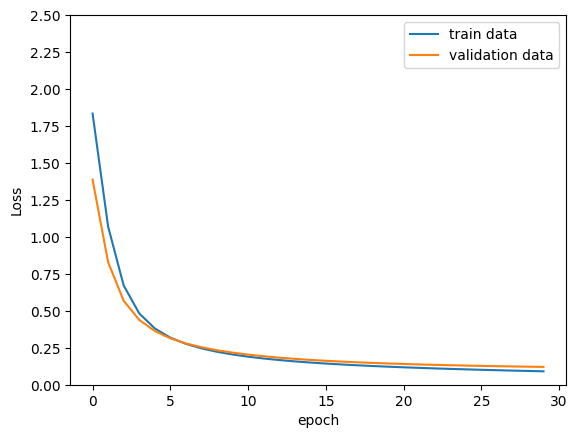

In [71]:
plt.plot(loss_per_epoch_train, label='train data')
plt.plot(loss_per_epoch_val, label='validation data')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.yticks(np.linspace(0.0, 2.5, 11))
plt.legend()